__To run the following analysis please download the full dataset from https://doi.org/10.5281/zenodo.15807706 and place the extracted folder in the root directory of the project__

In [1]:
!pip install -q matplotlib==3.9.4
!pip install -q fastplot
!pip install -q numpy==1.23.3
!pip install -q pandas==1.5.0
!pip install -q seaborn==0.12.0
!pip install -q venn==0.1.3
!pip install -q pyarrow==18.1.0

In [2]:
import pandas as pd
import numpy as np
import fastplot
%matplotlib inline
import matplotlib.pyplot as plt
from venn import venn
from cycler import cycler
import statistics
import matplotlib.patches as mpatches
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='fastplot')

THRESHOLD = 0.7
EPSS_V3_RELEASE_DATE = pd.to_datetime('2023-03-07', format='%Y-%m-%d')
UPPER_DATE = '2024-09-30'

In [3]:
PLOT_ARGS = {'style': 'latex',
             'grid': True,
             'figsize': (6, 3),
             'rcParams': {'text.latex.preamble': r'\usepackage{amsmath}'},
             'xtick_direction': 'out',
             'ytick_direction': 'out',
             'xtick_width': 0.8,
             'ytick_width': 0.8,
             'xtick_length': 3.5,
             'ytick_length': 3.5,
            }

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c']) +
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

cc1=(cycler('color', ['k', 'r', 'b', 'g', 'purple']) + 
     cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]) + 
     cycler('marker', ['o', 's', 'v', 'd', '^' ]))

lbl_df_current = '\\textsf{NVD}'
lbl_df_current_above = '\\textsf{NVD}$_{\\text{EPSS}}$'

lbl_df_pz_current = '\\textsf{PZ}'
lbl_df_pz_current_above = '\\textsf{PZ}$_{\\text{EPSS}}$'

lbl_df_kev_current = '\\textsf{KEV}'
lbl_df_kev_current_above = '\\textsf{KEV}$_{\\text{EPSS}}$'

# Data loading

In [4]:
df_current = pd.read_parquet('datasets/epss_v3_current.parquet')
id_current = set(df_current.cve)

id_epss_rejected = set()
with open('datasets/cve_ids/id_rejected_21-24.txt', 'r') as f:
    for l in f.readlines():
        id_epss_rejected.add(l.strip())

df_epss_rejected = df_current[df_current.cve.isin(id_epss_rejected)].copy()

id_above = set(df_current.groupby('cve').filter(lambda e: (e['epss'] > THRESHOLD).any()).cve)
df_current_above = df_current[df_current.cve.isin(id_above)].copy()

In [5]:
df_pz_sheet = pd.read_parquet('datasets/cve_pz_2024-10-01.parquet')
id_pz = set(df_pz_sheet['CVE'])

df_pz_current = df_current[df_current['cve'].isin(id_pz)]
df_pz_current_above = df_pz_current[df_pz_current.cve.isin(id_above)]


df_kev_sheet = pd.read_parquet('datasets/cve_kev_2024-10-01.parquet')
id_kev = set(df_kev_sheet['cveID'])

df_kev_current = df_current[df_current['cve'].isin(id_kev)]
df_kev_current_above = df_kev_current[df_kev_current.cve.isin(id_above)]

df_cve = pd.read_parquet('datasets/cve_first_info_21-24.parquet')
df_cve['reserved'] = pd.to_datetime(df_cve['reserved'], utc=True).dt.tz_localize(None)
df_cve['published'] = pd.to_datetime(df_cve['published'], utc=True).dt.tz_localize(None)
df_cve['cvssCreated'] = pd.to_datetime(df_cve['cvssCreated'], utc=True).dt.tz_localize(None)
df_cve['cpeCreated'] = pd.to_datetime(df_cve['cpeCreated'], utc=True).dt.tz_localize(None)

In [6]:
df_time_t = pd.merge(df_current_above[df_current_above.epss > THRESHOLD].drop_duplicates(subset='cve', keep='first')[['cve', 'date']],
                     df_cve[['id', 'reservationYear', 'published', 'cvssCreated', 'daysToCVSS', 'cvssBaseScore', 'cpeCreated', 'daysToCPE']],
                     left_on='cve', 
                     right_on='id',
                     how='inner').set_index('id')
df_time_t.drop(columns=['cve'], inplace=True)
df_time_t.rename(columns={'date': 'dateAbove', 'daysToCVSS': 'deltaCVSS', 'cvssCreated': 'dateCVSS',
                          'daysToCPE': 'deltaCPE', 'cpeCreated': 'dateCPE'}, inplace=True)
df_time_t['deltaEPSS'] = (df_time_t.dateAbove.dt.date -  df_time_t.published.dt.date).dt.days

df_exploit = pd.read_csv('datasets/exploitdb_above.csv')
df_exploit['Date'] = pd.to_datetime(df_exploit['Date'])

df_exploit_merged = pd.merge(df_exploit, df_cve[['id', 'published']], left_on='CVE', right_on='id', how='inner')
df_exploit_merged['deltaExploit'] = (df_exploit_merged['Date'].dt.date - df_exploit_merged['published'].dt.date).dt.days
df_exploit_merged.rename(columns={'Date': 'dateExploit'}, inplace=True)

df_time_t = pd.merge(df_time_t, 
                      df_exploit_merged[['CVE', 'dateExploit', 'deltaExploit']], 
                      left_on=df_time_t.index, 
                      right_on='CVE', 
                      how='left').set_index(df_time_t.index)
df_time_t.drop(columns=['CVE'], inplace=True)

df_kev_date = df_kev_sheet[df_kev_sheet['cveID'].isin(id_above)][['cveID', 'dateAdded']].set_index('cveID')
df_kev_date.rename(columns={'dateAdded': 'dateKEV'}, inplace=True)
df_kev_date['dateKEV'] = pd.to_datetime(df_kev_date['dateKEV'])
df_time_t = pd.merge(df_kev_date, df_time_t, left_index=True, right_index=True, how='right')
df_time_t['deltaKEV'] = (df_time_t.dateKEV.dt.date - df_time_t.published.dt.date).dt.days

df_time_t = df_time_t[['reservationYear', 'published', 'dateAbove', 'deltaEPSS', 'dateKEV', 'deltaKEV', 'dateCVSS', 'deltaCVSS', 'cvssBaseScore', 'dateCPE', 'deltaCPE', 'dateExploit', 'deltaExploit']]
df_time_t['T-KEV'] = df_time_t['deltaEPSS'] - df_time_t['deltaKEV']
df_time_t['T-CVSS'] = df_time_t['deltaEPSS'] - df_time_t['deltaCVSS']
df_time_t['T-CPE'] = df_time_t['deltaEPSS'] - df_time_t['deltaCPE']
df_time_t['T-exploit'] = df_time_t['deltaEPSS'] - df_time_t['deltaExploit']
df_time_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, CVE-2023-28771 to CVE-2024-5932
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   reservationYear  137 non-null    int64         
 1   published        137 non-null    datetime64[ns]
 2   dateAbove        137 non-null    datetime64[ns]
 3   deltaEPSS        137 non-null    int64         
 4   dateKEV          58 non-null     datetime64[ns]
 5   deltaKEV         58 non-null     float64       
 6   dateCVSS         131 non-null    datetime64[ns]
 7   deltaCVSS        131 non-null    float64       
 8   cvssBaseScore    137 non-null    float64       
 9   dateCPE          131 non-null    datetime64[ns]
 10  deltaCPE         131 non-null    float64       
 11  dateExploit      12 non-null     datetime64[ns]
 12  deltaExploit     12 non-null     float64       
 13  T-KEV            58 non-null     float64       
 14  T-CVSS           131 non

# Analysis

## Cardinality

<Figure size 640x480 with 0 Axes>

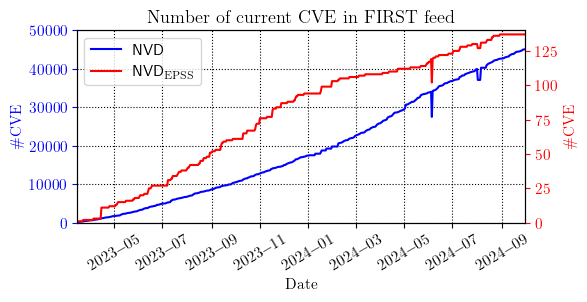

In [7]:
def double_ts_callback(plt, index, ldata, rdata, llbl, rlbl):
    plt.close()
    fig, ax1 = plt.subplots(figsize=(6, 3))

    line1, = ax1.plot(index, ldata, color='b', label=llbl)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('\#CVE', color='b')
    ax1.tick_params('y', colors='b')
    ax1.grid(True, which='major', axis='both', linestyle='dotted', color='black')
    
    ax2 = ax1.twinx()
    line2, = ax2.plot(index, rdata, color='r', label=rlbl)
    ax2.set_ylabel('\#CVE', color='r')
    ax1.set_xlim(left=index.min(), right=index.max())
    ax2.tick_params('y', colors='r')
    
    plt.setp(ax1.get_xticklabels(), rotation=30)
    
    lines = [line1, line2]
    ax1.legend(lines, [llbl, rlbl], loc='best')
    
    plt.plot(linewidth=1)
    
    
ldata = df_current.groupby('date').size().loc['2023-03-15':]
rdata = df_current_above.groupby('date').size()
plot = fastplot.plot(None, None, mode='callback', callback=lambda plt: double_ts_callback(plt, 
                                                                                          ldata.index, 
                                                                                          ldata, 
                                                                                          rdata, 
                                                                                          f'{lbl_df_current}', 
                                                                                          f'{lbl_df_current_above}'), 
                     **PLOT_ARGS)
plot.title('Number of current CVE in FIRST feed')
plot.show()

In [8]:
print('Number of unique CVEs for each dataframe')
print(f'{lbl_df_current}: {len(set(df_current["cve"]))}')
print(f'{lbl_df_current_above}: {len(set(df_current_above["cve"]))}')
print()
print(f'{lbl_df_pz_current}: {len(set(df_pz_current["cve"]))}')
print(f'{lbl_df_pz_current_above}: {len(set(df_pz_current_above["cve"]))}')
print()
print(f'{lbl_df_kev_current}: {len(set(df_kev_current["cve"]))}')
print(f'{lbl_df_kev_current_above}: {len(set(df_kev_current_above["cve"]))}')

Number of unique CVEs for each dataframe
\textsf{NVD}: 45080
\textsf{NVD}$_{\text{EPSS}}$: 137

\textsf{PZ}: 68
\textsf{PZ}$_{\text{EPSS}}$: 3

\textsf{KEV}: 182
\textsf{KEV}$_{\text{EPSS}}$: 58


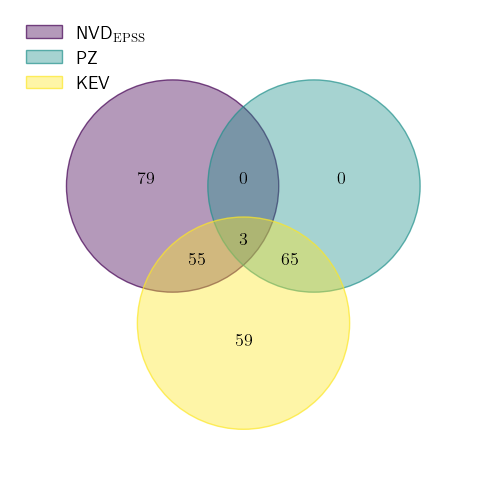

In [9]:
data = {f'{lbl_df_current_above}': set(df_current_above["cve"]), 
        lbl_df_pz_current: set(df_pz_current["cve"]),
        lbl_df_kev_current: set(df_kev_current["cve"])
       }
plt.rcParams['legend.frameon'] = False
fig = venn(data, figsize=(5, 5), legend_loc='upper left')
fig = fig.figure
plt.tight_layout()
fig.show()

In [10]:
set(df_current_above["cve"]) & set(df_pz_current["cve"]) & set(df_kev_current["cve"])

{'CVE-2023-36761', 'CVE-2023-36884', 'CVE-2023-4762'}

## Delay between publication and first EPSS Score

In [11]:
df_t = df_current.drop_duplicates(subset='cve', keep='first')[['cve', 'date']]
df_timings = pd.merge(df_t, df_cve[['id', 'published']], left_on='cve', right_on='id', how='inner')
df_timings.drop(columns=['id'], inplace=True)
df_timings['date'] = pd.to_datetime(df_timings['date'])
df_timings['daysDiff'] = (df_timings['date'].dt.date - df_timings['published'].dt.date).dt.days
df_timings_above = df_timings[df_timings['cve'].isin(id_above)]

In [12]:
df_timings_above.groupby('daysDiff').size()

daysDiff
0      20
1     102
2       3
3       1
5       3
6       3
7       1
8       2
10      1
16      1
dtype: int64

In [13]:
print('Vulnearbilities with negative delay', len(df_timings[df_timings.daysDiff < 0].cve))

Vulnearbilities with negative delay 684


## EPSS values

In [14]:
id_cve_min = set(df_current.groupby('cve').filter(lambda e: (e['epss'] > 0.01).any())['cve'])
print(f'{len(id_cve_min)} vulnerabilities with EPSS > 0.01 on entire period, i.e., {len(id_cve_min) / len(df_current) * 100}%')

877 vulnerabilities with EPSS > 0.01 on entire period, i.e., 0.008084144420981682%


<Figure size 640x480 with 0 Axes>

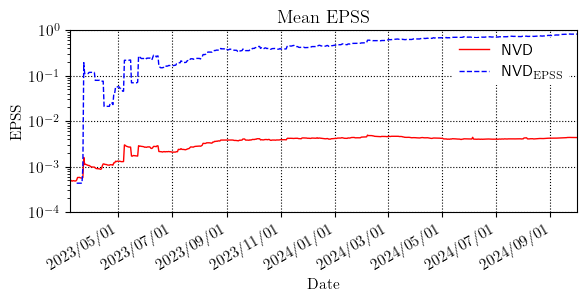

In [15]:
data = [(f'{lbl_df_current}', df_current.groupby('date')['epss'].mean()),
        (f'{lbl_df_current_above}', df_current_above.groupby('date')['epss'].mean())]
plot = fastplot.plot(data, None, mode='timeseries_multi', xlabel='Date', xticks_rotate=30, 
                     ylabel='EPSS', yscale='log', legend=True, **PLOT_ARGS)
plot.title('Mean EPSS')
plot.show()

<Figure size 640x480 with 0 Axes>

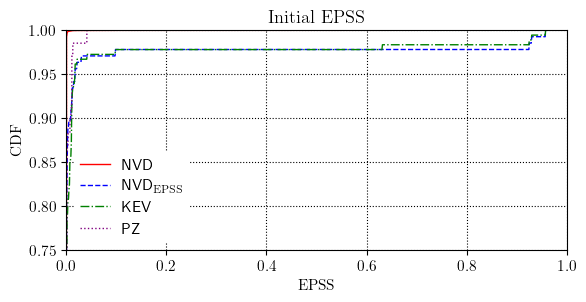

In [16]:
def compute_first_epss(df):
    return df.groupby('cve')['epss'].first()


data = [(f'{lbl_df_current}', compute_first_epss(df_current)),
        (f'{lbl_df_current_above}', compute_first_epss(df_current_above)),
        (f'{lbl_df_kev_current}', compute_first_epss(df_kev_current)),
        (f'{lbl_df_pz_current}', compute_first_epss(df_pz_current))]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='EPSS', ylim=(0.75, 1), legend=True, **PLOT_ARGS)
plot.title('Initial EPSS')
plot.show()

In [17]:
first_epss_above = df_current_above.groupby('cve')['epss'].first()
len(first_epss_above[first_epss_above.values < 0.01]) / len(first_epss_above) * 100

90.51094890510949

<Figure size 640x480 with 0 Axes>

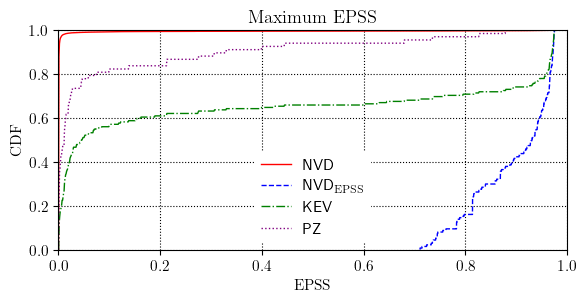

In [18]:
def compute_max_epss(df):
    return df.groupby('cve')['epss'].max()


data = [(f'{lbl_df_current}', compute_max_epss(df_current)),
        (f'{lbl_df_current_above}', compute_max_epss(df_current_above)),
        (f'{lbl_df_kev_current}', compute_max_epss(df_kev_current)),
        (f'{lbl_df_pz_current}', compute_max_epss(df_pz_current))]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='EPSS', legend=True, **PLOT_ARGS)
plot.title('Maximum EPSS')
plot.show()

<Figure size 640x480 with 0 Axes>

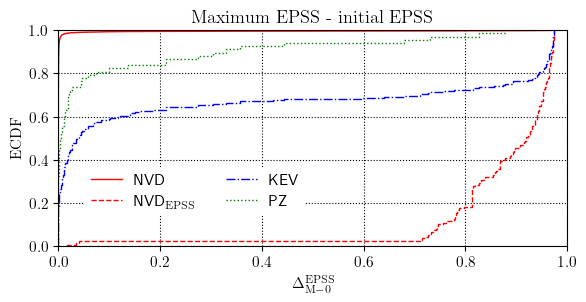

In [19]:
def compute_epss_diff(df):
    grouped = df.groupby('cve')['epss']
    diff = grouped.max() - grouped.first()
    return diff


def ecdf_colored_callback(plt, data, labels):
    colors = ['red', 'red', 'blue', 'green', 'purple', 'cyan']
    linestyles = ['-', '--', '-.', ':']
    for i, el in enumerate(data):
        #ls = linestyles[0] if i % 2 == 0 else linestyles[1]
        #c = colors[0] if i < 2 else colors[i]
        #c = colors[i // 2]
        plt.ecdf(el, label=labels[i], color=colors[i], linestyle=linestyles[i], linewidth=1)


data = [compute_epss_diff(e) for e in [df_current, df_current_above, df_kev_current, df_pz_current]]
labels = [f'{lbl_df_current}', f'{lbl_df_current_above}', f'{lbl_df_kev_current}', f'{lbl_df_pz_current}']
        
plot = fastplot.plot(None, None, mode='callback', callback=lambda plt: ecdf_colored_callback(plt, data, labels),
                     xlabel='$\Delta^\\text{EPSS}_{\\text{M}-0}$', ylabel='ECDF', legend=True, legend_ncol=2, legend_args={'bbox_to_anchor' : (0.5, 0.4)}, **PLOT_ARGS)
plot.title('Maximum EPSS - initial EPSS')
plot.show()

In [20]:
born_high = compute_epss_diff(df_current_above)
born_high[born_high < 0.7]

cve
CVE-2023-46805    0.04144
CVE-2024-21887    0.01646
CVE-2024-21893    0.03501
Name: epss, dtype: float64

In [21]:
pz_three = compute_epss_diff(df_pz_current_above)
pz_three

cve
CVE-2023-36761    0.73095
CVE-2023-36884    0.87823
CVE-2023-4762     0.82592
Name: epss, dtype: float64

## Focus on $T$

### Number of CVE exceeding threshold day by day

<Figure size 640x480 with 0 Axes>

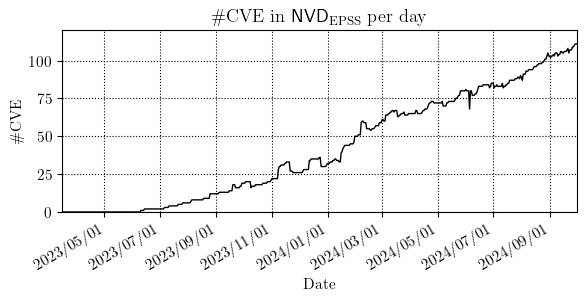

reservationYear
2023    100
2024     37
dtype: int64

In [22]:
data = df_current_above.groupby('date')['epss'].apply(lambda e: len([v for v in e.values if v > 0.7]))
plot = fastplot.plot(data, None, mode='timeseries', xlabel='Date', xticks_rotate=30, ylabel='\#CVE', 
                     cycler=cc, **PLOT_ARGS)
plot.title(f'\#CVE in {lbl_df_current_above} per day')
plot.show()

df_cve[df_cve.id.isin(df_current_above['cve'].unique())].groupby('reservationYear').size()

In [23]:
print(df_current[df_current.date == '2024-06-04'].groupby('date').size())
print(df_current[df_current.date == '2024-06-05'].groupby('date').size())
print(df_current[df_current.date == '2024-06-06'].groupby('date').size())

date
2024-06-04    34016
dtype: int64
date
2024-06-05    27509
dtype: int64
date
2024-06-06    34202
dtype: int64


### Days to reach $T$

<Figure size 640x480 with 0 Axes>

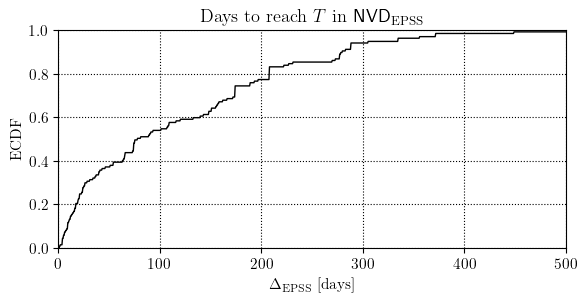

In [24]:
plot = fastplot.plot(df_time_t[df_time_t.index.isin(id_above)].deltaEPSS.values, None, mode='CDF', 
                     xlabel='$\\Delta_{\\text{EPSS}}$ [days]', xlim=(0, 500), ylabel='ECDF', **PLOT_ARGS, cycler=cc)
plot.title(f'Days to reach $T$ in {lbl_df_current_above}')
plot.show()

<Figure size 640x480 with 0 Axes>

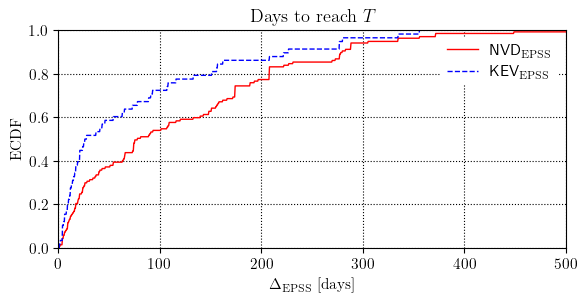

\textsf{NVD}$_{\text{EPSS}}$: 78.0
\textsf{KEV}$_{\text{EPSS}}$: 27.0


In [25]:
data = [(f'{lbl_df_current_above}', df_time_t[df_time_t.index.isin(id_above)].deltaEPSS.values), 
        (f'{lbl_df_kev_current_above}', df_time_t[df_time_t.index.isin(id_above & id_kev)].deltaEPSS.values)]

plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='$\\Delta_{\\text{EPSS}}$ [days]', xlim=(0, 500), 
                     ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Days to reach $T$')
plot.show()

print(f'{data[0][0]}:', np.median(data[0][1]))
print(f'{data[1][0]}:', np.median(data[1][1]))

In [26]:
less_7 = (sum(1 for e in df_time_t.deltaEPSS if e <= 7))
more_365 = (sum(1 for e in df_time_t.deltaEPSS if e > 365))
print(f'{less_7 / df_time_t.index.nunique() * 100} ({less_7}) <= 1 week')
print(f'{more_365 / df_time_t.index.nunique() * 100} ({more_365}) > 1 year')

8.02919708029197 (11) <= 1 week
2.9197080291970803 (4) > 1 year


Pre: 92 vulns
Post: 45 vulns


<Figure size 640x480 with 0 Axes>

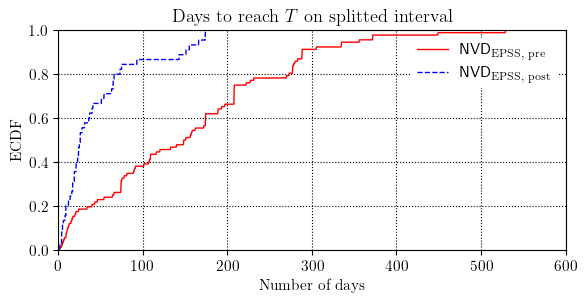

\textsf{NVD}$_{\text{EPSS, pre}}$: 149.5
\textsf{NVD}$_{\text{EPSS, post}}$: 26.0


In [27]:
df_cve_epss = df_cve[df_cve.reserved >= EPSS_V3_RELEASE_DATE]
id_pre = set(df_cve_epss[df_cve_epss.published <= pd.to_datetime('18/12/2023', format='%d/%m/%Y')].id.values) & id_above
id_post = set(df_cve_epss[df_cve_epss.published > pd.to_datetime('18/12/2023', format='%d/%m/%Y')].id.values) & id_above

print(f'Pre: {len(id_pre)} vulns')
print(f'Post: {len(id_post)} vulns')

data = [('\\textsf{NVD}$_{\\text{EPSS, pre}}$', df_time_t[df_time_t.index.isin(id_pre)].deltaEPSS.values),
        ('\\textsf{NVD}$_{\\text{EPSS, post}}$', df_time_t[df_time_t.index.isin(id_post)].deltaEPSS.values)]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='Number of days', ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Days to reach $T$ on splitted interval')
plot.show()

print(f'{data[0][0]}:', np.median(data[0][1]))
print(f'{data[1][0]}:', np.median(data[1][1]))

<Figure size 640x480 with 0 Axes>

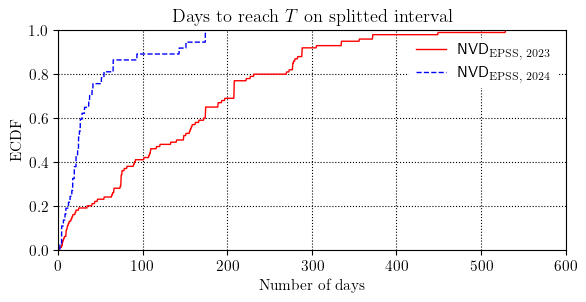

\textsf{NVD}$_{\text{EPSS, 2023}}$: 144.0
100
\textsf{NVD}$_{\text{EPSS, 2024}}$: 24.0
37


In [28]:
data = [('\\textsf{NVD}$_{\\text{EPSS, 2023}}$', df_time_t.groupby('reservationYear').deltaEPSS.apply(list)[2023]),
        ('\\textsf{NVD}$_{\\text{EPSS, 2024}}$', df_time_t.groupby('reservationYear').deltaEPSS.apply(list)[2024])]
plot = fastplot.plot(data, None, mode='CDF_multi', xlabel='Number of days', ylabel='ECDF', legend=True, **PLOT_ARGS)
plot.title('Days to reach $T$ on splitted interval')
plot.show()

print(f'{data[0][0]}:', np.median(data[0][1]))
print(len(data[0][1]))
print(f'{data[1][0]}:', np.median(data[1][1]))
print(len(data[1][1]))

### Let $T$ varies

In [29]:
#thresholds = [round(x * 0.01, 2) for x in range(1, 21)]
thresholds = [round(x * 0.05, 2) for x in range(1, 20)]
n_cve = df_current.cve.nunique()

data_t = defaultdict(dict)
max_epss = df_current.groupby('cve').epss.max()
for t in thresholds:
    data_t[t]['x'] = (max_epss > t).sum()
    df = pd.merge(df_current[df_current.epss > t].drop_duplicates(subset='cve', keep='first')[['cve', 'date']], 
                  df_cve[['id', 'reservationYear', 'published']], 
                  left_on='cve', 
                  right_on='id',
                  how='inner').set_index('id')
    df.drop(columns=['cve'], inplace=True)
    df['deltaEPSS'] = (df.date.dt.date -  df.published.dt.date).dt.days
    data_t[t]['y'] = (df['deltaEPSS'].median())

<Figure size 640x480 with 0 Axes>

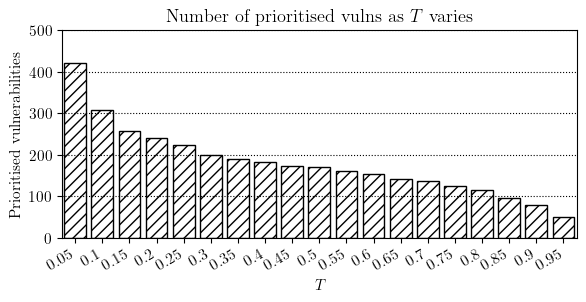

In [30]:
def bar_hatch_callback(plt, data, color='black'):
    yy = [d[1] for d in data]
    xticks_labels_from_data = [d[0] for d in data]
    xx = range(len(yy))
    plt.bar(xx, yy, linewidth=1, align='center', width=0.8, facecolor='none', edgecolor=color, hatch='///')
    plt.xticks(xx, xticks_labels_from_data)
    plt.xlim((-0.5, len(xx) - 0.5))
    

plot_args_copy = PLOT_ARGS.copy()
del plot_args_copy['grid']
ts = [(t, data_t[t]['x']) for t in data_t.keys()]
plot = fastplot.plot(None, None, mode='callback', xlabel='$T$', callback=lambda plt: bar_hatch_callback(plt, ts),
                     xticks_rotate=30, ylabel='Prioritised vulnerabilities', 
                     grid=True, grid_axis='y', **plot_args_copy)
plot.title('Number of prioritised vulns as $T$ varies')
plot.show()

<Figure size 640x480 with 0 Axes>

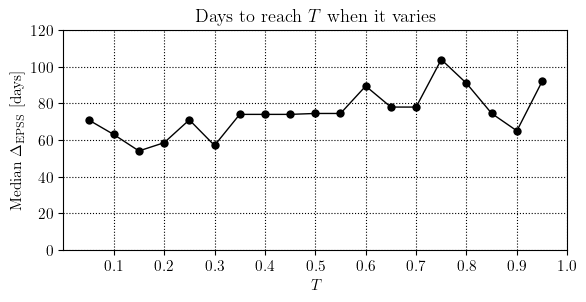

In [31]:
y = [data_t[k]['y'] for k in data_t.keys()]

plot = fastplot.plot((list(data_t.keys()), y), None, xlabel='$T$', xticks=([round(x * 0.1, 2) for x in range(1, 11)], None), 
                     ylabel='Median $\\Delta_{\\text{EPSS}}$ [days]', ylim=(0, 120), cycler=cc1, **PLOT_ARGS)
plot.title('Days to reach $T$ when it varies')
plot.show()

<Figure size 640x480 with 0 Axes>

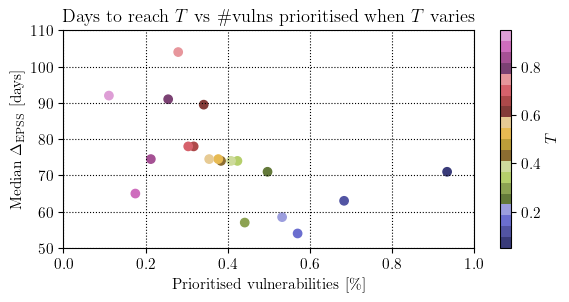

In [32]:
def scatter_heat_callback(plt, x, y):
    color = [T for T in thresholds]
    scatter = plt.scatter(x, y, c=color, cmap='tab20b')
    plt.colorbar(scatter, label='$T$')
    

x = [data_t[k]['x'] / n_cve * 100 for k in data_t.keys()]
y = [data_t[k]['y'] for k in data_t.keys()]
plot = fastplot.plot(None, None, mode='callback', callback=lambda plt: scatter_heat_callback(plt, x, y),
                     xlabel='Prioritised vulnerabilities [\%]', ylabel='Median $\\Delta_{\\text{EPSS}}$ [days]',
                     #xlim=(30, 450), ylim=(41, 110), 
                     **PLOT_ARGS)
plot.title('Days to reach $T$ vs \#vulns prioritised when $T$ varies')
plot.show()

<Figure size 640x480 with 0 Axes>

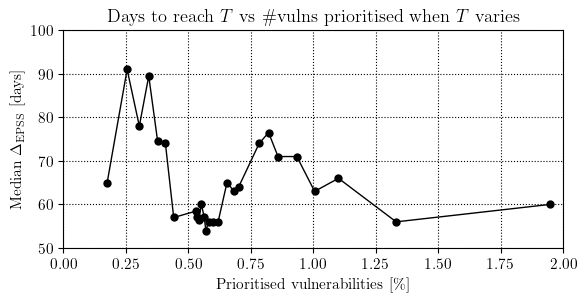

In [33]:
Ts = [round(x * 0.01, 2) for x in range(1, 21)] + [round(x * 0.1, 2) for x in range(3, 10)]

data_t1 = defaultdict(dict)
max_epss = df_current.groupby('cve').epss.max()
n_cve = df_current.cve.nunique()
for t in Ts:
    data_t1[t]['x'] = (max_epss > t).sum()
    df = pd.merge(df_current[df_current.epss > t].drop_duplicates(subset='cve', keep='first')[['cve', 'date']], 
                  df_cve[['id', 'reservationYear', 'published']], 
                  left_on='cve', 
                  right_on='id',
                  how='inner').set_index('id')
    df.drop(columns=['cve'], inplace=True)
    df['deltaEPSS'] = (df.date.dt.date -  df.published.dt.date).dt.days
    data_t1[t]['y'] = (df['deltaEPSS'].median())

x = [data_t1[k]['x'] / n_cve * 100 for k in data_t1.keys()]
y = [data_t1[k]['y'] for k in data_t1.keys()]

plot = fastplot.plot((x, y), None, xlabel='Prioritised vulnerabilities [\%]',
                     ylabel='Median $\\Delta_{\\text{EPSS}}$ [days]', cycler=cc1, **PLOT_ARGS)
plot.title('Days to reach $T$ vs \#vulns prioritised when $T$ varies')
plot.show()

<Figure size 640x480 with 0 Axes>

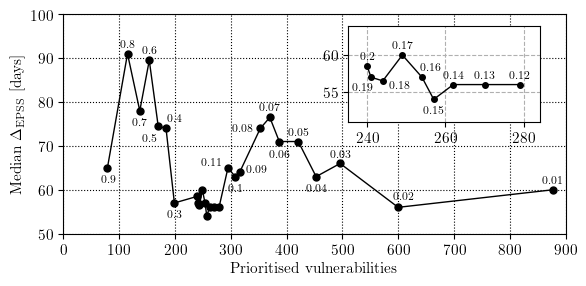

In [34]:
n_cve = df_current.cve.nunique()
k = list(data_t1.keys())
x = [data_t1[k]['x'] for k in data_t1.keys()]
y = [data_t1[k]['y'] for k in data_t1.keys()]


def test_callback(plt, kk, ax, ay):
    subkeys = [round(e * 0.01, 2) for e in range(12, 21)]
    
    plt.plot(ax, ay, linewidth=1, markersize=5)
    plt.xlabel('Prioritised vulnerabilities')
    plt.ylabel('Median $\\Delta_{\\text{EPSS}}$ [days]')
    
    index_avoid = list()
    for e in subkeys:
        index_avoid.append(list(data_t1.keys()).index(e))

    for i, (xi, yi) in enumerate(zip(ax, ay)):
        if i not in index_avoid:
            xyt = place_labels(kk[i])
            if xyt:
                plt.annotate(f'{kk[i]}', (xi, yi), textcoords="offset points", xytext=xyt, ha='center', fontsize=8)
            else:
                plt.annotate(f'{kk[i]}', (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    #Zoom
    zoom_plot = plt.axes([.59, .57, .32, .32])
    x1 = [data_t1[k]['x'] for k in subkeys]
    y1 = [data_t1[k]['y'] for k in subkeys]
    plt.plot(x1, y1, linewidth=1, markersize=4)
    for i, (xi, yi) in enumerate(zip(x1, y1)):
        xyt = place_labels(subkeys[i])
        if xyt:
            plt.annotate(f'{subkeys[i]}', (xi, yi), textcoords="offset points", xytext=xyt, ha='center', fontsize=8)
        else:
            plt.annotate(f'{subkeys[i]}', (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    plt.xlim(235, 284)
    plt.ylim(51, 64)
    plt.grid(linestyle='--')
    

def place_labels(value):
    offsets = {
        0.9: (1, -10), 0.7: (0, -10), 0.5: (-6, -11), 0.4: (6, 5),
        0.3: (0, -10), 0.19: (-6.5, -9.5), 0.18: (12, -5), 0.16: (6, 5),
        0.15: (0, -10), 0.11: (-12, 2), 0.10: (0, -10), 0.09: (12, 0),
        0.08: (-13, -2), 0.06: (0, -11), 0.04: (0, -10), 0.02: (4, 6)
    }
    return offsets.get(value)
    
    
plot = fastplot.plot(None, None, mode='callback', callback=lambda plt: test_callback(plt, k, x, y), cycler=cc1, **PLOT_ARGS)
plot.show()

### Time trend of CVEs above threshold

<Figure size 640x480 with 0 Axes>

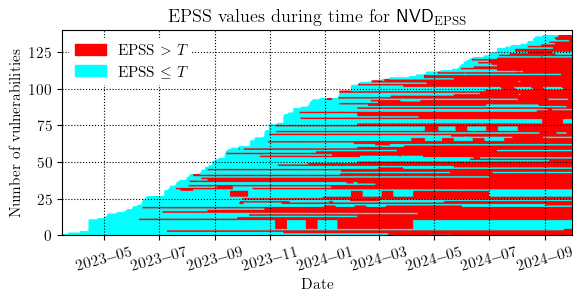

In [35]:
def t_colored_callback(plt):
    df = df_current_above.copy()
    ydict = {v: k for k, v in enumerate(df.cve.unique())}
    df['tkn'] = df.cve.apply(lambda x: ydict[x])
    df['color'] = np.where(df['epss'] > 0.7, 'red', 'cyan')
    df.sort_values(by=['date', 'tkn'], inplace=True)
    plt.scatter(df.date, df.tkn, s=0.5, c=df['color'])
    plt.xlabel('Date')
    plt.xticks(rotation=15)
    plt.ylabel('Number of vulnerabilities')
    red_patch = mpatches.Patch(color='red', label=r'EPSS $> T$')
    cyan_patch = mpatches.Patch(color='cyan', label=r'EPSS $\le T$')
    legend = plt.legend(handles=[red_patch, cyan_patch])
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(1)
    

data = df_current.groupby('date')['epss'].apply(lambda e: len([v for v in e.values if v > 0.7]))
plot_args_copy = PLOT_ARGS.copy()
del plot_args_copy['figsize']
plot = fastplot.plot(None, None, mode='callback', callback=t_colored_callback, **PLOT_ARGS)
plt.title(f'EPSS values during time for {lbl_df_current_above}')
plot.show()

In [36]:
df_temp = df_current_above[df_current_above.date == UPPER_DATE]
print(len(df_temp[df_temp.epss > THRESHOLD]))

111


In [37]:
df_temp = df_current_above.groupby('cve').first()
print(len(df_temp[df_temp.epss > THRESHOLD]))
print(df_temp[df_temp.epss > THRESHOLD].index.values)

3
['CVE-2023-46805' 'CVE-2024-21887' 'CVE-2024-21893']


In [38]:
set(df_current_above.cve).intersection(set(df_pz_current.cve))

{'CVE-2023-36761', 'CVE-2023-36884', 'CVE-2023-4762'}

In [39]:
results = {}
swinging_down = 0
grouped = df_current_above.groupby('cve')

for cve, group in grouped:
    surpassed = group['epss'] > 0.7
    
    if surpassed.any():
        first_surpass_index = surpassed.idxmax()
        remaining_epss = group.loc[first_surpass_index:]['epss']
        
        if (remaining_epss > 0.7).all():
            results[cve] = 'up'
        else:
            is_swing = False
            is_switched = False
            for v in remaining_epss:
                if v <= 0.7:
                    is_switched = True
                if v > 0.7 and is_switched:
                    is_swing = True
                    results[cve] = 'sw'
                    break
            if not cve in results:
                results[cve] = 'down'
            if results[cve] == 'sw':
                if remaining_epss.values[-1] <= 0.7:
                    swinging_down = swinging_down + 1

up = sum(1 for status in results.values() if status == 'up')
down = sum(1 for status in results.values() if status == 'down')
swinging = sum(1 for status in results.values() if status == 'sw')

print('Always above T after first occurence', up)
print('Down after reached T', down)
print(f'Swinging {swinging} of which {swinging_down} below T on last day')

Always above T after first occurence 92
Down after reached T 15
Swinging 30 of which 11 below T on last day


## Filtering capacity

/tmp/ipykernel_1324/2813617770.py:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_cve_d = df_cve[df_cve.reserved.dt.date >= pd.to_datetime('2023-03-07', format='%Y-%m-%d')].copy()


<Figure size 640x480 with 0 Axes>

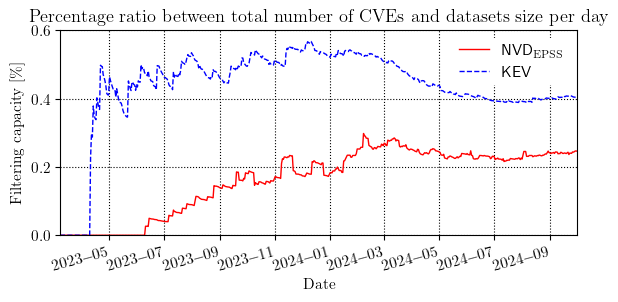

In [40]:
cve_per_day_epss = df_current.groupby('date').size()
above = df_current[df_current['epss'] > 0.7].groupby('date').size()
percentage_epss = (above / cve_per_day_epss * 100).fillna(0)

kev_temp = df_kev_sheet[df_kev_sheet.cveID.isin(id_current)].sort_values('dateAdded')
kev_temp['dateAdded'] = pd.to_datetime(kev_temp['dateAdded'])
cumulative_counts = kev_temp.groupby(kev_temp['dateAdded'].dt.date).size().cumsum()
cumulative_counts.index = pd.to_datetime(cumulative_counts.index)
cumulative_counts_filled = cumulative_counts.reindex(
    pd.date_range(start=cve_per_day_epss.index.min(), end=UPPER_DATE, freq='D'),
    method='ffill'
)
cumulative_counts_filled = cumulative_counts_filled.fillna(0)
df_cve_d = df_cve[df_cve.reserved.dt.date >= pd.to_datetime('2023-03-07', format='%Y-%m-%d')].copy()
df_cve_d = df_cve_d[~df_cve_d.id.isin(id_epss_rejected)]
cve_per_day = df_cve_d.groupby(df_cve_d.published.dt.date).size().cumsum()
cve_per_day_filled = cve_per_day.reindex(
    pd.date_range(start=cve_per_day.index.min(), end=UPPER_DATE, freq='D'),
    method='ffill')
percentage_kev = (cumulative_counts_filled / cve_per_day_filled * 100)

data = [(f'{lbl_df_current_above}', (percentage_epss.index, percentage_epss.values)), 
        (f'{lbl_df_kev_current}', (percentage_kev.index, percentage_kev.values))]
plot = fastplot.plot(data, None, mode='line_multi', xlabel='Date', ylabel='Filtering capacity [\%]', 
                     xticks_rotate=15, legend=True, **PLOT_ARGS)
plot.title('Percentage ratio between total number of CVEs and datasets size per day')
plot.show()

In [41]:
cve_per_day_filled[cve_per_day_filled.index == '2023-04-10']

2023-04-10    882
Freq: D, dtype: int64

In [42]:
for k, v in cumulative_counts_filled.items():
    if v > 0:
        print(k, v)
        break

2023-04-10 00:00:00 2.0


<Figure size 640x480 with 0 Axes>

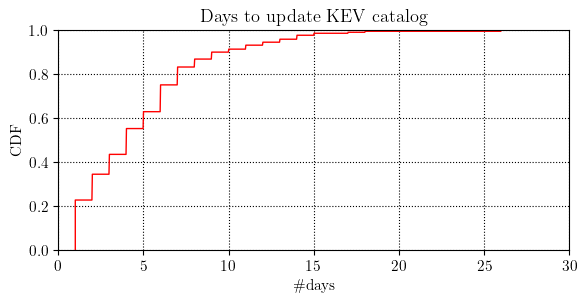

Median #CVE added 2.0


In [43]:
date_index = df_kev_sheet.groupby('dateAdded').size().index
date_index = pd.to_datetime(date_index)
days_diff = date_index.to_series().diff().dt.days.dropna().tolist()
plot = fastplot.plot(days_diff, None, mode='CDF', xlabel='\#days', **PLOT_ARGS)
plot.title('Days to update KEV catalog')
plot.show()
print('Median #CVE added', statistics.median(df_kev_sheet.groupby('dateAdded').size().values))

## Combining CVSS, CPE and KEV to vulnerabilities $\in \textsf{NVD}_{\text{EPSS}}$

In [44]:
print('Median deltaCVSS', df_time_t.dropna(subset=['deltaCVSS']).deltaCVSS.median())
print('Median deltaCPE', df_time_t.dropna(subset=['deltaCPE']).deltaCPE.median())

Median deltaCVSS 5.0
Median deltaCPE 7.0


### $\Delta_{\text{EPSS}}$ vs $\Delta_{\text{CVSS}}$ / $\Delta_{\text{CPE}}$ / Base score

<Figure size 640x480 with 0 Axes>

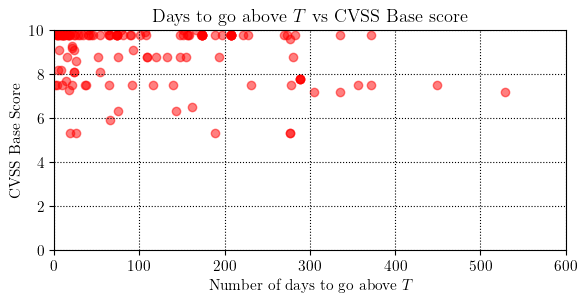

In [45]:
def days_callback(plt):
    plt.scatter(df_time_t['deltaEPSS'].tolist(), df_time_t['cvssBaseScore'].tolist(), alpha=0.5)

    
plot = fastplot.plot(None, None, mode='callback', callback=days_callback, ylim=(0, 10), xlabel='Number of days to go above $T$', ylabel='CVSS Base Score', **PLOT_ARGS)
plot.title('Days to go above $T$ vs CVSS Base score')
plot.show()

<Figure size 640x480 with 0 Axes>

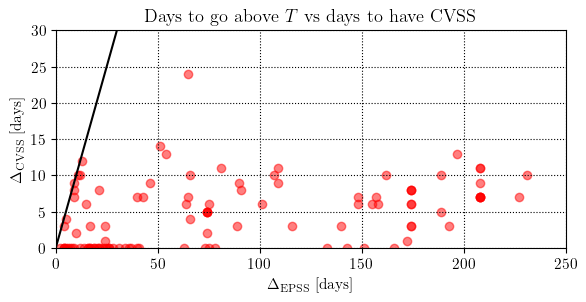

Out x axis 20
Out y axis 4


In [46]:
def days_cvss_callback(plt):
    df_time_t_nona = df_time_t.dropna(subset=['deltaCVSS'])
    plt.scatter(df_time_t_nona['deltaEPSS'].tolist(), df_time_t_nona['deltaCVSS'].tolist(), alpha=0.5)


plot = fastplot.plot(None, None, mode='callback', xlim=(0, 250), ylim=(0,30), 
                     callback=days_cvss_callback,
                     xlabel='$\\Delta_{\\text{EPSS}}$ [days]', ylabel='$\\Delta_{\\text{CVSS}}$ [days]', **PLOT_ARGS)
plot.plot((0, 250), (0, 250), 'black')
plot.title('Days to go above $T$ vs days to have CVSS')
plot.show()

print('Out x axis', len(df_time_t[df_time_t.deltaEPSS > 250]))
print('Out y axis', len(df_time_t[df_time_t.deltaCVSS > 30]))

<Figure size 640x480 with 0 Axes>

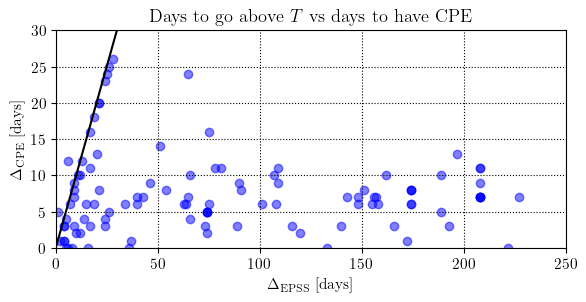

Out x axis 20
Out y axis 4


In [47]:
def days_cpe_callback(plt):
    merged_nona = df_time_t.dropna(subset=['deltaCPE'])
    plt.scatter(df_time_t['deltaEPSS'].tolist(), df_time_t['deltaCPE'].tolist(), alpha=0.5, c='b')

    
plot = fastplot.plot(None, None, mode='callback', xlim=(0, 250), ylim=(0, 30), 
                     callback=days_cpe_callback,
                     xlabel='$\\Delta_{\\text{EPSS}}$ [days]', ylabel='$\\Delta_{\\text{CPE}}$ [days]', **PLOT_ARGS)
plot.plot((0, 250), (0, 250), 'black')
plot.title('Days to go above $T$ vs days to have CPE')
plot.show()

print('Out x axis', len(df_time_t[df_time_t.deltaEPSS > 250]))
print('Out y axis', len(df_time_t[df_time_t.deltaCPE > 30]))

### Difference between $\Delta_{\text{EPSS}}$ and $\Delta_{\text{CVSS}}$, $\Delta_{\text{CPE}}$ and $\Delta_{\text{KEV}}$

In [48]:
merged_nona = df_time_t.dropna(subset=['T-KEV']).copy()
print('Median days delay between exceeding $T$ and insertion in KEV is ', merged_nona['T-KEV'].median())
neg = len(merged_nona[merged_nona["T-KEV"] < 0])
pos = len(merged_nona[merged_nona["T-KEV"] >= 0])
print(f'{round(neg / merged_nona.index.nunique() * 100, 2)} ({neg}) have negative delay')
print(f'{round(pos / merged_nona.index.nunique() * 100, 2)} ({pos}) have positive delay')

Median days delay between exceeding $T$ and insertion in KEV is  5.0
17.24 (10) have negative delay
82.76 (48) have positive delay


<Figure size 640x480 with 0 Axes>

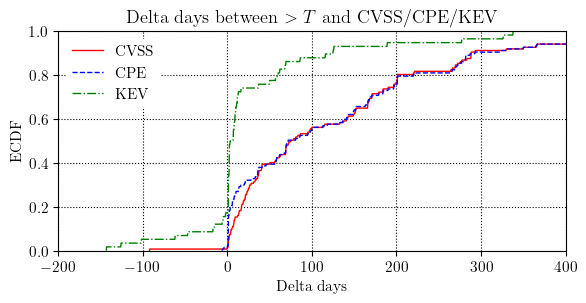

In [49]:
data = [('CVSS', df_time_t['T-CVSS'].values), 
        ('CPE', df_time_t['T-CPE'].values), 
        ('KEV', merged_nona['T-KEV'].values)]
plot = fastplot.plot(data, None, mode='CDF_multi', legend=True, xlim=(-200, 400), xlabel='Delta days', 
                     ylabel='ECDF', **PLOT_ARGS)
plot.title('Delta days between $>T$ and CVSS/CPE/KEV')
plot.show()

In [50]:
df_time_t[df_time_t['T-CVSS'] < 0]

,reservationYear,published,dateAbove,deltaEPSS,dateKEV,deltaKEV,dateCVSS,deltaCVSS,cvssBaseScore,dateCPE,deltaCPE,dateExploit,deltaExploit,T-KEV,T-CVSS,T-CPE,T-exploit
id,,,,,,,,,,,,,,,,,
CVE-2023-46747,2023,2023-10-26 21:15:08.097,2023-11-01,6,2023-10-31,5.0,2024-02-01 02:15:55.947,98.0,9.8,2023-11-07 15:44:55.027,12.0,NaT,NaN,1.0,-92.0,-6.0,NaN


In [51]:
df_time_t[df_time_t['T-CPE'] < 0]

,reservationYear,published,dateAbove,deltaEPSS,dateKEV,deltaKEV,dateCVSS,deltaCVSS,cvssBaseScore,dateCPE,deltaCPE,dateExploit,deltaExploit,T-KEV,T-CVSS,T-CPE,T-exploit
id,,,,,,,,,,,,,,,,,
CVE-2023-38205,2023,2023-09-14 08:15:07.767,2023-09-15,1,2023-07-20,-56.0,NaT,NaN,7.5,2023-09-19 17:27:19.623,5.0,NaT,NaN,57.0,NaN,-4.0,NaN
CVE-2023-46747,2023,2023-10-26 21:15:08.097,2023-11-01,6,2023-10-31,5.0,2024-02-01 02:15:55.947,98.0,9.8,2023-11-07 15:44:55.027,12.0,NaT,NaN,1.0,-92.0,-6.0,NaN


In [52]:
less_7_kev = set(df_time_t[df_time_t['T-KEV'] < 7].index)
print(len(less_7_kev))
print(len(less_7_kev) / len(set(df_time_t[~df_time_t.dateKEV.isna()].index)) * 100)

29
50.0


### Split on 18th December 2023

In [53]:
df_cve_epss = df_cve[df_cve.reserved >= EPSS_V3_RELEASE_DATE]
id_pre = set(df_cve_epss[df_cve_epss.published <= pd.to_datetime('18/12/2023', format='%d/%m/%Y')].id.values) & id_above
id_post = set(df_cve_epss[df_cve_epss.published > pd.to_datetime('18/12/2023', format='%d/%m/%Y')].id.values) & id_above

In [54]:
def days_callback(plt, col):
    merged_nona_pre = df_time_t[df_time_t.index.isin(id_pre)].dropna(subset=[col])
    plt.scatter(merged_nona_pre['deltaEPSS'].tolist(), merged_nona_pre[col].tolist(), alpha=0.5, c='r')
    print(f'Median {col} pre', np.median(merged_nona_pre[col].tolist()))
    merged_nona_post = df_time_t[df_time_t.index.isin(id_post)].dropna(subset=[col])
    plt.scatter(merged_nona_post['deltaEPSS'].tolist(), merged_nona_post[col].tolist(), alpha=0.5, c='b')
    print(f'Median {col} post', np.median(merged_nona_post[col].tolist()))
    
    red_patch = mpatches.Patch(color='red', label='pre')
    blue_patch = mpatches.Patch(color='blue', label='post')
    legend = plt.legend(handles=[red_patch, blue_patch])
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(1)

Median deltaCVSS pre 6.0
Median deltaCVSS post 0.0


<Figure size 640x480 with 0 Axes>

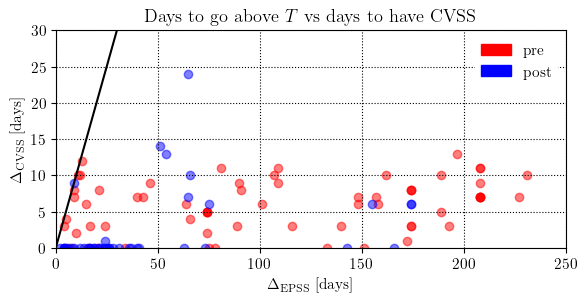

In [55]:
plot = fastplot.plot(None, None, mode='callback', xlim=(0, 250), ylim=(0,30), 
                     callback=lambda plt: days_callback(plt, 'deltaCVSS'),
                     xlabel='$\\Delta_{\\text{EPSS}}$ [days]', ylabel='$\\Delta_{\\text{CVSS}}$ [days]', **PLOT_ARGS)
plot.plot((0, 250), (0, 250), 'black')
plot.title('Days to go above $T$ vs days to have CVSS')
plot.show()

Median deltaCPE pre 7.0
Median deltaCPE post 6.0


<Figure size 640x480 with 0 Axes>

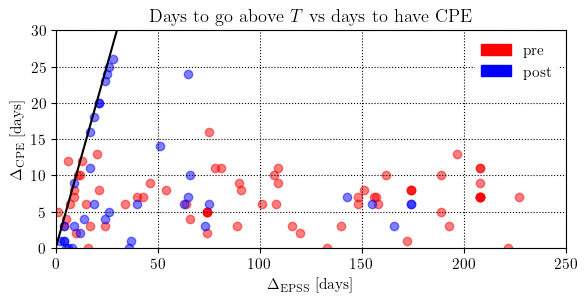

In [56]:
plot = fastplot.plot(None, None, mode='callback', xlim=(0, 250), ylim=(0, 30), 
                     callback=lambda plt: days_callback(plt, 'deltaCPE'),
                     xlabel='$\\Delta_{\\text{EPSS}}$ [days]', ylabel='$\\Delta_{\\text{CPE}}$ [days]', **PLOT_ARGS)
plot.plot((0, 250), (0, 250), 'black')
plot.title('Days to go above $T$ vs days to have CPE')
plot.show()

## EPSS score distribution before and after reaching $T$

In [57]:
df_current_below = df_current[~df_current.cve.isin(id_above)][['cve', 'epss', 'date']]
below_max = df_current_below.sort_values(['cve', 'epss'], ascending=[True, False]).drop_duplicates(subset='cve', keep='first')[['cve', 'epss', 'date']]
below_max.rename(columns={'date': 'dateMax', 'epss': 'epssMax'}, inplace=True)

below_max = below_max[(below_max.epssMax > 0.1) & (below_max.epssMax <= 0.5)]

df_below = pd.merge(df_current_below, below_max, on='cve', how='inner')
df_below['diffDays'] = (df_below['date'] - df_below['dateMax']).dt.days
df_filtered_below = df_below[(df_below['diffDays'] >= -30) & (df_below['diffDays'] <= 30)].copy()

df_above = pd.merge(df_current_above, df_time_t['dateAbove'], left_on='cve', right_index=True, how='inner')
df_above['diffDays'] = (df_above['date'] - df_above['dateAbove']).dt.days
df_filtered_above = df_above[(df_above['diffDays'] >= -30) & (df_above['diffDays'] <= 30)].copy()

In [58]:
windows = [e for e in range(1, 7, 2)]

for i in windows:
    df_filtered_below[f'rollingAvg-{i}'] = df_filtered_below.groupby('cve')['epss'].transform(lambda x: x.rolling(window=i, min_periods=1).mean())
    df_filtered_above[f'rollingAvg-{i}'] = df_filtered_above.groupby('cve')['epss'].transform(lambda x: x.rolling(window=i, min_periods=1).mean())

rolls_below = dict()
rolls_above = dict()
for i in windows:
    rolls_below[i] = df_filtered_below.groupby('diffDays')[f'rollingAvg-{i}'].median()
    rolls_above[i] = df_filtered_above.groupby('diffDays')[f'rollingAvg-{i}'].median()

<Figure size 640x480 with 0 Axes>

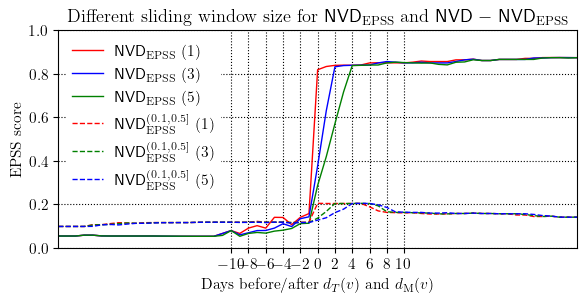

In [59]:
lbl = '\\textsf{NVD}$_{\\text{EPSS}}^{(0.1, 0.5]}$'
data_below = [(f'{lbl} ({i})', (rolls_below[i].index.values, rolls_below[i].values)) for i in windows]
data_above = [(f'{lbl_df_current_above} ({i})', (rolls_above[i].index.values, rolls_above[i].values)) for i in windows]
data = data_above + data_below

cc = (cycler('color',['r', 'b', 'g', 'r', 'g', 'b']) +
      cycler('linestyle',['-', '-', '-', '--', '--', '--']))

plot = fastplot.plot(data, None, mode='line_multi', xlabel='Days before/after $d_T(v)$ and $d_\\text{M}(v)$', ylabel='EPSS score', 
                     xticks=([e for e in range(-10, 12, 2)], None), legend=True, cycler=cc, **PLOT_ARGS)
plot.title(f'Different sliding window size for {lbl_df_current_above} and {lbl_df_current} $-$ {lbl_df_current_above}')
plot.show()

<Figure size 640x480 with 0 Axes>

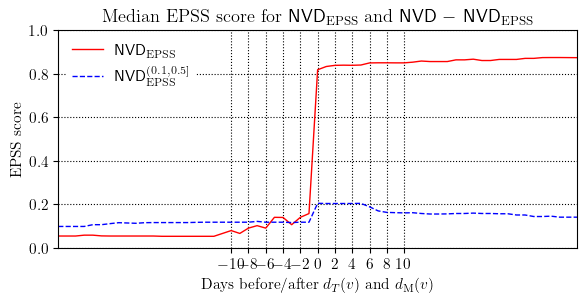

In [60]:
lbl = '\\textsf{NVD}$_{\\text{EPSS}}^{(0.1, 0.5]}$'
data_below = df_filtered_below.groupby('diffDays').epss.median()
data_below = [(f'{lbl}', (data_below.index.values, data_below.values))]
data_above = df_filtered_above.groupby('diffDays').epss.median()
data_above = [(f'{lbl_df_current_above}', (data_above.index.values, data_above.values))]
data = data_above + data_below

plot = fastplot.plot(data, None, mode='line_multi', xlabel='Days before/after $d_T(v)$ and $d_\\text{M}(v)$', ylabel='EPSS score', 
                     xticks=([e for e in range(-10, 12, 2)], None), legend=True, **PLOT_ARGS)
plot.title(f'Median EPSS score for {lbl_df_current_above} and {lbl_df_current} $-$ {lbl_df_current_above}')
plot.show()

<Figure size 640x480 with 0 Axes>

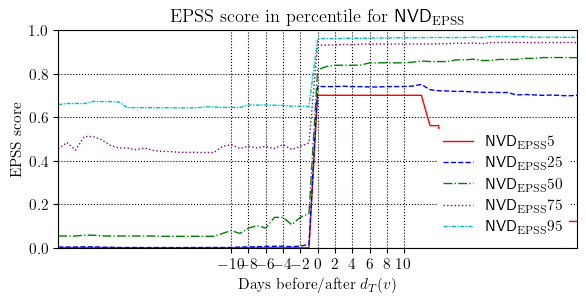

In [61]:
data = {}
percentiles = [0.05, 0.25, 0.50, 0.75, 0.95]
for p in percentiles:
    data[p] = df_filtered_above.groupby('diffDays').epss.quantile(p)

data = [(f'{lbl_df_current_above}{int(p * 100)}', (data[p].index.values, data[p].values)) for p in percentiles]

plot = fastplot.plot(data, None, mode='line_multi', xlabel='Days before/after $d_T(v)$', ylabel='EPSS score', 
                     xticks=([e for e in range(-10, 12, 2)], None), legend=True, **PLOT_ARGS)
plot.title(f'EPSS score in percentile for {lbl_df_current_above}')
plot.show()

<Figure size 640x480 with 0 Axes>

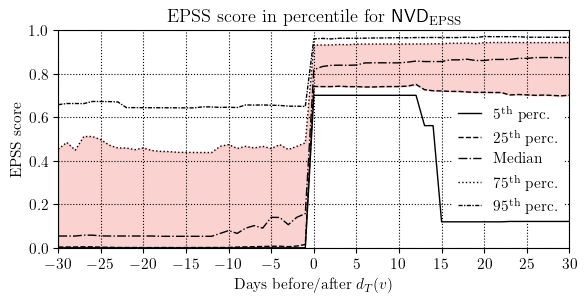

In [62]:
def percentiles_callback(plt):
    percentiles = [0.05, 0.25, 0.50, 0.75, 0.95]
    colors = ['#F6A8A4', '#F6A8A4', '#F6A8A4', '#F6A8A4']
    legend_names = {0.05: '$5^{\\text{th}}$ perc.',
                    0.25: '$25^{\\text{th}}$ perc.',
                    0.50: 'Median',
                    0.75: '$75^{\\text{th}}$ perc.',
                    0.95: '$95^{\\text{th}}$ perc.'}
    
    data = {p: df_filtered_above.groupby('diffDays').epss.quantile(p) for p in percentiles}

    plt.fill_between(data[0.25].index, data[0.25], data[0.75], color=colors[1], alpha=0.5)
    
    legend_lines = []
    for p in percentiles:
        l, = plt.plot(data[p].index, data[p], color='k', linewidth=1)
        legend_lines.append(l)
    
    legend = plt.legend(legend_lines, list(legend_names.values()), loc=(.77, .13), handlelength=1.5, ncols=1)
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(1)

plot = fastplot.plot(None, None, mode='callback', xlabel='Days before/after $d_T(v)$', callback=percentiles_callback,
                     ylabel='EPSS score', xticks=([e for e in range(-30, 35, 5)], None), **PLOT_ARGS)
plot.title(f'EPSS score in percentile for {lbl_df_current_above}')
plot.show()

In [63]:
df_before_t = pd.DataFrame()

for cve in df_current_above.cve.unique():
    temp = df_current_above[df_current_above.cve == cve]
    date_above = df_time_t.loc[df_time_t.index == cve, 'dateAbove'].values[0]
    temp = temp[temp.date < date_above]
    df_before_t = pd.concat([df_before_t, temp])
    
df_before_t.groupby('cve').apply(lambda x: (x['epss'] > 0.01).any()).sum()

108

## Network based or host based cardinalities

In [64]:
df_cve_av = df_cve[df_cve.id.isin((id_above | id_kev | id_pz) & id_current)].copy()
df_cve_av['attackVector'] = df_cve_av.apply(lambda r: 'network' if r['cvssVectorStringFull'].split('/')[1].split(':')[1] in ['N', 'A'] else 'host', axis=1)

In [65]:
df_cve_av = df_cve[df_cve.id.isin(id_current)].copy()
df_cve_av = df_cve_av.dropna(subset=['cvssBaseScore'])
df_cve_av['attackVector'] = df_cve_av.apply(lambda r: 'network' if r['cvssVectorStringFull'].split('/')[1].split(':')[1] in ['N', 'A'] else 'host', axis=1)

In [66]:
df_cve_av.groupby('cvssVersion').size()

cvssVersion
2.0        1
3.0     1393
3.1    38607
4.0     1781
dtype: int64

In [67]:
df_cve_av['cvssVectorStringFull'].astype(str).str.split('/').str[1].str.split(':').str[1].value_counts()

N    31756
L     8190
A     1467
P      369
Name: cvssVectorStringFull, dtype: int64

In [68]:
df_cve_av.attackVector.value_counts()

network    33223
host        8559
Name: attackVector, dtype: int64

In [69]:
df_cve_av[df_cve_av.id.isin(id_above & id_current)].attackVector.value_counts()

network    133
host         4
Name: attackVector, dtype: int64

In [70]:
df_cve_av[df_cve_av.id.isin(id_kev & id_current)].attackVector.value_counts()

network    134
host        48
Name: attackVector, dtype: int64

In [71]:
df_cve_av[df_cve_av.id.isin(id_pz & id_current)].attackVector.value_counts()

host       36
network    32
Name: attackVector, dtype: int64

## Top routinely exploited 2023

In [72]:
df_top15_web = pd.read_csv('datasets/CISA_top2023/top_15_exploited.csv')
df_additionals_web = pd.read_csv('datasets/CISA_top2023/additionals_exploited.csv')

id_top15 = set(df_top15_web.cve.values)
id_additionals = set(df_additionals_web.cve.values)

df_top15 = df_current[df_current.cve.isin(id_top15)]
df_additionals = df_current[df_current.cve.isin(id_additionals)]

id_top = id_top15.union(id_additionals)
df_top = df_current[df_current.cve.isin(id_top)]
df_top_limited = df_top[df_top.date <= pd.Timestamp('2023-12-31')].copy()
id_top_limited = set(df_top_limited.cve)
id_top_limited_above = set(df_time_t[(df_time_t.index.isin(id_top)) & (df_time_t.dateAbove.dt.year == 2023)].index)

print('Total vulns:', len(id_top))
print('Vulns reserved in 2023:', len(df_cve[(df_cve.id.isin(id_top)) & (df_cve.reservationYear == 2023)]))
print('Vulns in dEPSS:', len(id_current & id_top))
print('Vulns in 2023:', len(id_top_limited))
print('Vulns in dEPSS above T in \dEPSS:', len(id_current & id_top & id_above))
print('Vulns in dEPSS above T in 2023:', len(id_top_limited_above))

Total vulns: 47
Vulns reserved in 2023: 24
Vulns in dEPSS: 19
Vulns in 2023: 19
Vulns in dEPSS above T in \dEPSS: 10
Vulns in dEPSS above T in 2023: 5


In [73]:
df_top_cve = df_cve[df_cve.id.isin(id_top_limited)]

id_network_based = set()
for _, e in df_top_cve.iterrows():
    if e['cvssVectorStringFull'].split('/')[1].split(':')[1] in ['N', 'A']:
        id_network_based.add(e['id'])
        
id_host_based = (id_top & id_current) - id_network_based
print('Network-based', len(id_network_based))
print('Host-based', len(id_host_based))
print('Network-based above T', len(id_network_based & id_top_limited_above))
print('Host-based above T', len(id_host_based & id_top_limited_above))

Network-based 16
Host-based 3
Network-based above T 5
Host-based above T 0


In [74]:
df_kev_current[df_kev_current.cve.isin(id_top_limited)].cve.nunique()

19

In [75]:
df_time_t_top_limited = df_time_t[df_time_t.index.isin(id_top_limited_above)].copy()
print(df_time_t_top_limited.deltaEPSS.median())
print(df_time_t_top_limited.deltaKEV.median())
print(df_time_t_top_limited.deltaCVSS.median())
print(df_time_t_top_limited.deltaCPE.median())
print(df_time_t_top_limited['T-CVSS'].median())
print(df_time_t_top_limited['T-CPE'].median())
print(df_time_t_top_limited['T-KEV'].median())

12.0
0.0
8.0
8.0
8.0
8.0
12.0


In [76]:
df_time_t_top_limited[['dateAbove', 'dateKEV', 'T-KEV']]

,dateAbove,dateKEV,T-KEV
id,,,
CVE-2023-34362,2023-06-14,2023-06-02,12.0
CVE-2023-3519,2023-08-04,2023-07-19,16.0
CVE-2023-35078,2023-08-05,2023-07-25,11.0
CVE-2023-42793,2023-09-29,2023-10-04,-5.0
CVE-2023-4966,2023-10-31,2023-10-18,13.0


In [77]:
df_time_t[df_time_t.index.isin(id_top_limited)].deltaKEV

id
CVE-2023-34362     0.0
CVE-2023-3519      0.0
CVE-2023-35078     0.0
CVE-2023-42793    15.0
CVE-2023-4966      8.0
CVE-2023-36845    88.0
CVE-2023-44487     0.0
CVE-2023-49103     9.0
CVE-2023-36844    88.0
CVE-2023-35081    -3.0
Name: deltaKEV, dtype: float64

In [78]:
print('TOP 15\n')
print(f'Inside dataset {len(id_current & id_top15)}/{len(id_top15)}')
print(f'Above T {len(id_current & id_above & id_top15)}/{len(id_top15)}')
print()
print(f'Inside KEV {len(id_kev & id_top15)}/{len(id_top15)}')
print(f'Inside KEV current {len(id_current & id_kev & id_top15)}/{len(id_top15)}')
print()
print(f'Inside PZ {len(id_pz & id_top15)}/{len(id_top15)}')
print(f'Inside PZ current {len(id_current & id_pz & id_top15)}/{len(id_top15)}')

print('\n\nADDITIONALS\n')
print(f'Inside dataset {len(id_current & id_additionals)}/{len(id_additionals)}')
print(f'Above T {len(id_above & id_additionals)}/{len(id_additionals)}')
print()
print(f'Inside KEV {len(id_kev & id_additionals)}/{len(id_additionals)}')
print(f'Inside KEV current {len(id_current & id_kev & id_additionals)}/{len(id_additionals)}')
print()
print(f'Inside PZ {len(id_pz & id_additionals)}/{len(id_additionals)}')
print(f'Inside PZ current {len(id_current & id_pz & id_additionals)}/{len(id_additionals)}')

TOP 15

Inside dataset 7/15
Above T 5/15

Inside KEV 15/15
Inside KEV current 7/15

Inside PZ 3/15
Inside PZ current 1/15


ADDITIONALS

Inside dataset 12/32
Above T 5/32

Inside KEV 32/32
Inside KEV current 12/32

Inside PZ 6/32
Inside PZ current 3/32


In [79]:
df_top15_time = df_kev_sheet[df_kev_sheet['cveID'].isin(id_top15 & id_above)][['cveID', 'dateAdded']]

merge_time_top15 = pd.merge(df_top15_time, df_time_t[df_time_t.index.isin(id_top15 & id_above)], 
                            left_on='cveID', right_index=True, how='inner')[['cveID', 'dateAdded', 'dateAbove', 'deltaEPSS', 'published']].set_index('cveID')
merge_time_top15.rename(columns={'dateAdded': 'dateKEV'}, inplace=True)
merge_time_top15['dateKEV'] = pd.to_datetime(merge_time_top15['dateKEV'])
merge_time_top15['T-KEV'] = (merge_time_top15['dateAbove'].dt.date - merge_time_top15['dateKEV'].dt.date).dt.days
merge_time_top15['deltaKEV'] = (merge_time_top15['dateKEV'].dt.date - merge_time_top15['published'].dt.date).dt.days

merge_time_top15

,dateKEV,dateAbove,deltaEPSS,published,T-KEV,deltaKEV
cveID,,,,,,
CVE-2023-49103,2023-11-30,2024-02-07,78,2023-11-21 22:15:08.277,69,9
CVE-2023-4966,2023-10-18,2023-10-31,21,2023-10-10 14:15:10.977,13,8
CVE-2023-42793,2023-10-04,2023-09-29,10,2023-09-19 17:15:08.330,-5,15
CVE-2023-3519,2023-07-19,2023-08-04,16,2023-07-19 18:15:11.513,16,0
CVE-2023-34362,2023-06-02,2023-06-14,12,2023-06-02 14:15:09.487,12,0


In [80]:
df_additionals_time = df_kev_sheet[df_kev_sheet['cveID'].isin(id_additionals & id_above)][['cveID', 'dateAdded']]

merge_time_additionals = pd.merge(df_additionals_time, df_time_t[df_time_t.index.isin(id_additionals & id_above)], 
                                  left_on='cveID', right_index=True, how='inner')[['cveID', 'dateAdded', 'dateAbove', 'deltaEPSS', 'published']].set_index('cveID')
merge_time_additionals.rename(columns={'dateAdded': 'dateKEV'}, inplace=True)
merge_time_additionals['dateKEV'] = pd.to_datetime(merge_time_additionals['dateKEV'])
merge_time_additionals['T-KEV'] = (merge_time_additionals['dateAbove'].dt.date - merge_time_additionals['dateKEV'].dt.date).dt.days
merge_time_additionals['deltaKEV'] = (merge_time_additionals['dateKEV'].dt.date - merge_time_additionals['published'].dt.date).dt.days

merge_time_additionals

,dateKEV,dateAbove,deltaEPSS,published,T-KEV,deltaKEV
cveID,,,,,,
CVE-2023-36844,2023-11-13,2024-05-20,277,2023-08-17 20:15:10.267,189,88
CVE-2023-36845,2023-11-13,2024-01-20,156,2023-08-17 20:15:10.360,68,88
CVE-2023-44487,2023-10-10,2024-02-03,116,2023-10-10 14:15:10.883,116,0
CVE-2023-35081,2023-07-31,2024-07-03,335,2023-08-03 18:15:11.303,338,-3
CVE-2023-35078,2023-07-25,2023-08-05,11,2023-07-25 07:15:10.897,11,0


In [81]:
first_epss = df_current[(df_current.cve.isin(id_top15)) | (df_current.cve.isin(id_additionals))].groupby('cve').epss.first()
print(f'{len(first_epss[first_epss > 0.1])}/{len(first_epss)} with first EPSS > 0.1')

last_epss = df_current_above[(df_current_above.cve.isin(id_top15)) | (df_current_above.cve.isin(id_additionals))].groupby('cve').epss.last()
print(f'{len(last_epss[last_epss > 0.7])}/{len(last_epss)} with last EPSS > 0.7')
print(last_epss[last_epss <= 0.7])

0/19 with first EPSS > 0.1
9/10 with last EPSS > 0.7
cve
CVE-2023-36844    0.45667
Name: epss, dtype: float64
